2024-03-29 12:08:48.480642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 12:08:48.480794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 12:08:48.588483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB

Time taken to complete process: 7.353404
Time Taken: 1.533364
PSNR Achieved: 34.040382


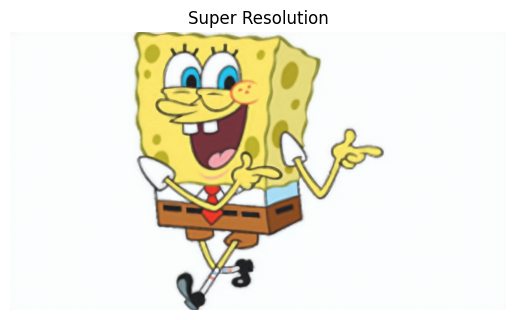

In [1]:
import os
import time 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
os.environ['TFHUB_DOWNLOAD_PROGRESS']='True'


import requests
url = 'https://raw.githubusercontent.com/greatgodme/projectdata/main/sb.jpg'
r = requests.get(url, allow_redirects=True)
open('tiger.jpg', 'wb').write(r.content)

IMAGE_PATH = 'tiger.jpg'
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"



# function to preprocess image so that it can be handled by model
def preprocess_image(image_path):
   '''Loads the image given make it ready for 
      the model
      Args:
        image_path: Path to the image file
   '''
   image = tf.image.decode_image(tf.io.read_file(image_path))
   if image.shape[-1] == 4:
     image = image[...,:-1]
   size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
   image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
   image = tf.cast(image,tf.float32)
   return tf.expand_dims(image,0)

def save_image(image,filename):
  ''' 
   Saves unscaled Tensor Images
   image: 3D image Tensor
   filename: Name of the file to be saved
  '''
  if not isinstance(image, Image.Image):
      image = tf.clip_by_value(image, 0, 255)
      image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save('%s.jpg' % filename)
  print('Saved as %s.jpg' % filename)
    
    
    
    
preprocess_image(IMAGE_PATH)


def plot_image(image,title=''):
  ''' 
  plots the Image tensors
  image: 3D image Tensor
  title: Title for plot
  '''
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis('off')
  plt.title(title)


model = hub.load(SAVED_MODEL_PATH)


load_image = preprocess_image(IMAGE_PATH)

# plot original image
plot_image(tf.squeeze(load_image),title='Original Photo')



# Start Performing resolution 
start = time.time()
super_image = model(load_image)
super_image = tf.squeeze(super_image)
print('Time taken to complete process: %f'%(time.time() - start))



#plot the output image 
plot_image(tf.squeeze(super_image),'Super Resolution')



IMAGE_PATH = "tiger.jpg"


def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image



hr_image = preprocess_image(IMAGE_PATH)


lr_image = downscale_image(tf.squeeze(hr_image))


# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")



start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))




plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 34.040382


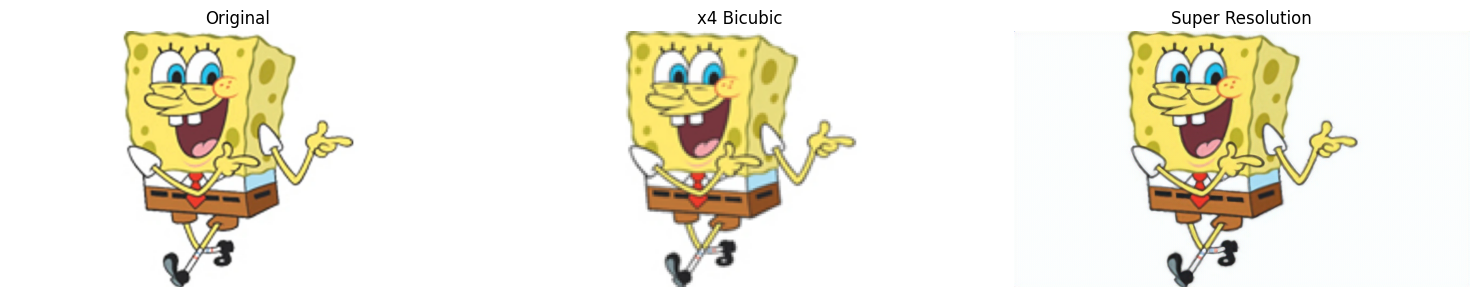

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)